In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re


In [18]:
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [19]:
df_initial= pd.read_csv("listings_summary.csv")

In [20]:
df_initial.shape

(22552, 96)

In [21]:
df_initial.duplicated().sum()

0

In [22]:
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

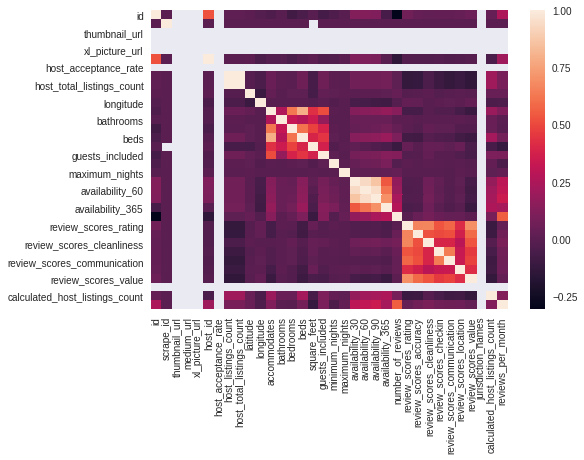

In [23]:
sns.heatmap(df_initial.corr())

In [24]:
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')

In [25]:
df_raw.shape

(22552, 23)

In [26]:
#how many room types we have
df_raw.room_type.value_counts(normalize = "True")

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

In [27]:
#And how many different property types are we up against?

df_raw.property_type.value_counts(normalize = "True")

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Houseboat                 0.000488
Camper/RV                 0.000488
Villa                     0.000443
Pension (South Korea)     0.000310
Aparthotel                0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Castle                    0.000089
Casa particular (Cuba)    0.000089
Train                     0.000089
In-law                    0.000044
Barn                

In [28]:
# Cleaning Price Columns
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)


,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


In [29]:
df_raw.price.isnull().sum()

0

In [30]:
# Nan's in "cleaning_fee" column
df_raw.cleaning_fee.isna().sum()/len(df_raw)

0.3168676835757361

In [31]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

In [32]:
df_raw.security_deposit.isna().sum()

9361

In [33]:
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [34]:
df_raw.extra_people.isna().sum()


0

In [35]:
#Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

df_raw.price = df_raw.price.str.replace('$','').str.replace(',','').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [36]:
df_raw['price'].describe()


count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

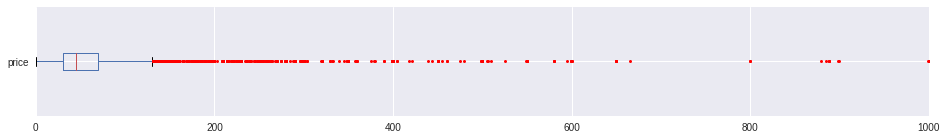

In [37]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [38]:
df_raw.drop(df_raw[ (df_raw.price > 400) | (df_raw.price == 0) ].index, axis=0, inplace=True)


In [39]:
df_raw['price'].describe()


count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [40]:
df_raw.shape

(22441, 23)

In [41]:
#Dealing with Missing Values
df_raw.isna().sum()


space                            8503
description                       202
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [42]:
# drop columns with too many Nan's
#df_raw.drop(columns=['square_feet', 'space'], inplace=True)


In [43]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [44]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space',],axis=1, inplace=True)

In [45]:
df_raw.host_has_profile_pic.unique()


array(['t', 'f', nan], dtype=object)

In [46]:
df_raw.host_has_profile_pic.fillna(value = 'f', inplace = True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [47]:
df_raw.isna().sum()


description                     202
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [48]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 22391 rows and 21 columns - after having dealt with missing values.


In [49]:
!pip install geopy

You are using pip version 19.0.2, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
from geopy.distance import great_circle

In [36]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [37]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)


In [38]:


df_raw.head(2)

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance
id,,,,,,,,,,,,,,,,,,,,,
2015,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,...,60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,3.533182
2695,In the summertime we are spending most of our ...,t,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,...,17.0,0.0,0.0,0.0,1,2,f,f,flexible,5.085573


In [39]:
df_raw.description.isna().sum()

202

In [40]:
# extract numbers 
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

# change datatype of size into float
df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3), '%')

NaNs in size_column absolute:      11721
NaNs in size_column in percentage: 0.523 %


In [41]:
df_raw[['description','size']].head(10)

,description,size
id,,
2015,Great location! 30 of 75 sq meters. This wood...,75.0
2695,In the summertime we are spending most of our ...,25.0
3176,This beautiful first floor apartment is situa...,68.0
3309,First of all: I prefer short-notice bookings. ...,26.0
7071,Cozy and large room in the beautiful district ...,20.0
9991,4 bedroom with very large windows and outstand...,780.0
14325,The apartment is located on the upper second f...,NaN
16401,Hello future guests! We want to rent our cute ...,55.0
16644,Light and sunny 2-Room-turn of the century-fla...,80.0


In [42]:
#drop description cloumns
df_raw.drop(['description'],axis =1,inplace=True)

In [43]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22391 entries, 2015 to 29867352
Data columns (total 22 columns):
host_has_profile_pic            22391 non-null object
neighbourhood_group_cleansed    22391 non-null object
latitude                        22391 non-null float64
longitude                       22391 non-null float64
property_type                   22391 non-null object
room_type                       22391 non-null object
accommodates                    22391 non-null int64
bathrooms                       22391 non-null float64
bedrooms                        22391 non-null float64
bed_type                        22391 non-null object
amenities                       22391 non-null object
price                           22391 non-null float64
cleaning_fee                    22391 non-null float64
security_deposit                22391 non-null float64
extra_people                    22391 non-null float64
guests_included                 22391 non-null int64
minimum_nights 

In [44]:
# filter out sub_df to work with
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [45]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]


In [46]:
# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [47]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (10670, 10)
Shape of Test Data:     (11721, 10)

Shape of X_train: (10670, 9)
Shape of X_test: (11721, 9)

Shape of y_train: (10670,)


In [48]:
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()
 
linreg.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
y_test = linreg.predict(X_test)

In [50]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(11721, 1)


,size
0,56.697281
1,97.756906
2,75.831592
3,88.778838
4,60.680846


In [51]:
print(X_test.shape)
X_test.head()

(11721, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509


In [52]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
14325,56.697281
20858,97.756906
21869,75.831592
22415,88.778838
28156,60.680846


In [53]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [54]:
print(new_test_data.shape)
new_test_data.head()

(11721, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.831592
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.778838
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,60.680846


In [55]:
new_test_data['size'].isna().sum()

0

In [56]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(22391, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.831592
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.778838
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,60.680846


In [57]:
sub_df_new['size'].isna().sum()

0

In [58]:
# prepare the multiple columns before concatening
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

In [59]:
df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

(22391, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible


In [60]:
df['size'].isna().sum()

0

In [61]:
df['size'].describe()

count    22391.000000
mean        60.297112
std         80.937597
min          0.000000
25%         25.000000
50%         49.573940
75%         65.014837
max        980.000000
Name: size, dtype: float64

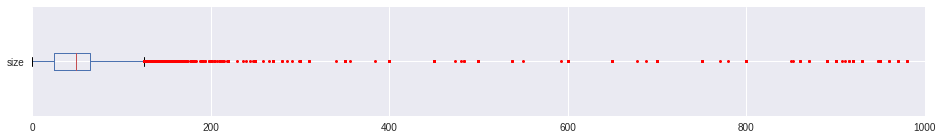

In [62]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [63]:
#To be on the safe side, let’s remove all outliers over 300 square meters, and all those with 0:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [64]:
df.shape

(21958, 22)

In [65]:
from collections import Counter

In [66]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

2015        None
2695        None
3176        None
3309        None
7071        None
14325       None
16401       None
16644       None
17409       None
20858       None
21869       None
22415       None
22677       None
23834       None
24569       None
25653       None
26543       None
28156       None
28268       None
29279       None
30295       None
31440       None
33043       None
35642       None
36480       None
37004       None
37052       None
37836       None
38074       None
38296       None
            ... 
29827481    None
29828388    None
29829280    None
29830204    None
29830381    None
29838765    None
29841234    None
29842909    None
29844866    None
29848269    None
29848527    None
29848903    None
29848907    None
29849186    None
29849565    None
29849958    None
29850404    None
29850644    None
29850727    None
29851223    None
29851651    None
29853463    None
29856029    None
29856359    None
29856646    None
29856708    None
29857108    None
29864272    No

In [67]:
results.most_common(30)

[('Wifi', 20952),
 ('Kitchen', 20809),
 ('Heating', 20657),
 ('Essentials', 19811),
 ('Washer', 18071),
 ('Hair dryer', 14474),
 ('Laptop friendly workspace', 14095),
 ('Hangers', 13514),
 ('Iron', 10876),
 ('Shampoo', 10339),
 ('TV', 9778),
 ('Hot water', 9421),
 ('Family/kid friendly', 7925),
 ('Internet', 7699),
 ('Host greets you', 6469),
 ('Smoke detector', 6245),
 ('Buzzer/wireless intercom', 5963),
 ('Lock on bedroom door', 5138),
 ('Free street parking', 5037),
 ('Refrigerator', 5033),
 ('Dishes and silverware', 4909),
 ('Elevator', 4703),
 ('Cooking basics', 4673),
 ('Bed linens', 4656),
 ('Stove', 4655),
 ('Smoking allowed', 4509),
 ('Oven', 4161),
 ('translation missing: en.hosting_amenity_50', 4095),
 ('First aid kit', 3866),
 ('Cable TV', 3577)]

In [70]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAsYAAAG4CAYAAABGqCGZAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzs3Xu8pWP9//HXdhpkELNLJ4bSO4p+ZZymMJtOo5LEzqGDpEQOhW/5Khr60kFRUnw1ZShkm0r0zTEzgzCOCfF2yDlC6CCa0/r9cd07y569Z/bMWnuvfXg/H4957LWu+76v+1qf8TCf+9rXuj5ttVqNiIiIiIjRbplWDyAiIiIiYihIYhwRERERQRLjiIiIiAggiXFEREREBJDEOCIiIiICSGIcEREREQEkMY6IiAZI+p2kWwbxfr+V9Nbq9ad6a4+IWFpt2cc4IiKWhqQ3AscB84FjbV8ziPdeFvir7dUH654RMfIt1+oBRETEsLUncC7wPPAx4BpJ44FrgBOATwJt1bEjgP8HXGx7LwBJOwDHAC8B7gF2t/2kpCnAOOBVwJuBJ4EP2H5U0v3AR4CjgdUk3QlMBmYAH7F91SL6fRPwQ2BVYAXgu7ZPGqjgRMTwk6UUERGxxKoZ252AnwO/AraXNKY6PA54zLaAPwDnAB8HNgZ2l/RaSa8BpgG72V6PktieUneLXYDPAa8FHgf26jGEvYD5tt9g+766cS2q368Ap9h+I7Al8I66MUdEZMY4IiKWyruB623/HUDSTOB9wI2Uf1vOrc67FcD2k9V5jwKvBDaqrr+tOu9k4PEq4Qa4wvYD1TU3A2v3c1zvX0S/jwMfknQrcLPtHZf4U0fEiJbEOCIilsaelFniZ6r3ywEvpSTG820/V7XPB/5Zd918YFlgdWDzailEt78Ba9a97nlNfyyq3y8ChwNdwIqSjrX9g372GxGjQBLjiIhYIpJWByYBa9ieU7UtBzwMtPezmz8Dl9neuZf+Gxlen/1WDgcOl7QpcJGky2zf1cgNI2LkyBrjiIhYUrsBl3cnxQC25wEXU9bu9sclwFaS1gOQtJmk7y7BGOYCy0ga299+JV1Q7aQBcBtlJnnBEtwzIka4zBhHRMSS+jjwnV7afwlM7U8Htv9c7UP8S0krAP+gfNmuvx4FrgIelPTefvb7PeCsqh3gB7bvWYJ7RsQIl32MIyIiIiLIUoqIiIiICCCJcUREREQEkMQ4IiIiIgJIYhwRERERAWRXimiSefPm155++l+tHsaw9tKXrkxi2LjEsXGJYXMkjo1LDJsjcVxYe/vYtt7aM2McTbHccv0tShV9SQybI3FsXGLYHIlj4xLD5kgc+y+JcUREREQEWUoRTdLV1dXqIURERMQw1tExudVDSGI8Wki6DdjB9p+q93cAh9j+TfX+l8A2wKuAdYDzKVWiXgt81/Z9LRl4RERExCBJYjx6zKAkvn+SNA5YGdga+E11fDPgNbafk7QZ8Bvb32vNUCMiIiIGX9YYjx4zKIkwwNuBnwBbAkjaALgPuF3Sa4DDgQ9JOkjSTElvasWAIyIiIgZTZoxHj5nAN6rXWwEXAJMkrURJmGcAHwWeBr4OvMn2dyV9sAVjjYiIiFGmvX1sq4eQxHi0sP2UpGclvQrYHPgycB2wBSVR/jElMY6IiIgYdE888Y9Bu1dfSXiWUowuM4B3AzXbzwFXAROBTYFrWjmwiIiIiFbLjPHoMgP4EjCren8V8F/Ao9WX7pa6487OzkF90huJ2tvHJoZNkDg2LjFsjsSxcYlhcySO/ZcZ49FlFrAJJSHG9uPAGpT1xxERERGjWmaMRxHbf6PH37lt1b0eX72cVtc2aRCGFhEREdFymTGOiIiIiCCJcUREREQEkMQ4IiIiIgLIGuOWkTQeuBW4scehnWw/1eR7rQpsYfsSSYcBs2z3uj2bpPspxT3+uST36OrqanicERERMfJ0dExu9RD6LYlxa3mQvtz2VuBdwCW2vz4I94uIiIgYdpIYDzGS3gX8D/Ac8BdgD6Cjl7Z2YCowBpgP7G37QUn3AOcBbwOeAd4LfB9YVdJdlIIe04ErgLOAlwArAwfYvm5R47A9d0A/fEREREQLJTEeevYHDrF9paSdgDX7aPsqcLztyyRtDxwBfApYDzjD9qGSrgU2Bo6jLI84VdLE6j5rAVNtnydpW+CLwIcWM47HBvrDR0RExMjSV/nloSiJcWtJ0sy69wbOBU6RdCZwtu3HJPXWNrG6/svAssATVR9/t/2H6vXDwGp93PsvwBGSDqXMOj/b4/hC92zso0ZERMRoNBSr7vWVrCcxbq1e1xhLuhjYEbhA0s62f9KzDZgD7GL70R6Xz+vxvq2Pe38OeMT2RyVNAL7VY2AL3dP2nUv6ASMiIiKGiyTGQ4ykI4CTqmUPLwM2lLRLzzZgNiVpPblaCrGW7bP66HYBZVa43jige2b5g8AKixsH0Gdi3NnZOSSfCIeT1LJvjsSxcYlhcySOjUsMmyNx7L8kxq3VcykFwAzgMklPA08DxwNje2m7FjhN0m5ADdhzEfe5CfiGpAfq2s4AzuhOuoHdJH2i7viDvdwzIiIiYsRqq9VqrR5DjAy1PI02Jk/0zZE4Ni4xbI7EsXGJYXMkjgtrbx/b61LTVL6LiIiIiCCJcUREREQEkMQ4IiIiIgJIYhwRERERAWRXij5J+izwUeB5Ssnkw21f1kB/T9oe18D17wN2tr1nH8dXBbawfckS9rsDcJHtOUs7NoCurq5GLo+IiIhhpKNjcquHMCAyY9wLSeMp5ZW3qgpw7EEpuTyUvRV411JcdzA99jCOiIiIGI0yY9y71YAVKQnjXNt3A9sAVPsOzwDeSSmccTplD+H5wHbAKsA0YHVgeeBA2zd1dyzp/wE/oCSx7wIOoVSru8H2IfWDkLQRZb/hR4A/17XvR0nWFwDn2f428H1gVUl3Ab8GplKKeswH9rb9oKSPAgdW1x1ffb4tgAslbQfsC+xa3eY829+QNI1SZW9N2x9ammBGREREDAdJjHth+xZJ1wH3SfoN8BvgF7a7yy0/avvtkn4HrGF7K0lXAhsBOwDXVknlBOAEXkiq1wROATqrfr4MbGn735K6JL3N9u/qhnIEMMX2rySdXPWxLrAL8PbqnN9JOhc4DnhTVanuR8Dxti+TtD1whKSDga9UYxwDnG77A5K+CkwGXkVJ8Det+r1O0vTq9VO2P91oXCMiImJkaG8f2+ohDIgkxn2w/TFJGwDvAb4A7FuVXga4rvr5KHBz9fovlJnmCcAxVR83SFJ1fBngHOCb1ezt5sDawMXVKasB6wD1ifGGwNXV65mUBHYzYH3KrDWUqnjjewx/IqWq3peBZYEngA2AO2w/BzwHfKDHNW+hJPTzKBfPBt7c4/NGREREDPuCIX0l9kmMeyGpDRhj+w7gDkknAndSElkoSx/o5XUbpTxzb9VUVgVuBT4D/IKyPOFG2+9exFDaKMse4IX14HOA/7O9T48xr1f3dg6wi+1H645vwqLXlPcc9zJ1927oi3kRERERw0ES4959Etha0sdt1yizucsAj/fj2uuBDuBaSVsAt1Xtz9j+vKTTJX0KOBPYQNLLbD8u6SjgVNuP1PVlygz0xVWfADcC35C0MmXm9zvAYZQkdkx1zmxgR+DkapZ7LeBXlFnkVSjJ/AWUNc7d190MTJHU/d/E5sCxVT+L1dnZOeyfHlstJTubI3FsXGLYHIlj4xLD5kgc+y+7UvTuNEoSPFvS5cD5lC/RPdePa78LbFJd93XgoB7HP0f5wt2a1evfVGuV16TuC3aV/6Ekwf9HNWtr+0FKMnwFcC3wWDWum4CdJR0KTAF2lHQFZV3xNbafBY4ELqUsy/hRlfTPBGYB/wROrV5fCUy1/UA/Pm9ERETEiNBWq9VaPYYYGWp5Gm1MnuibI3FsXGLYHIlj4xLD5kgcF9bePra3Za+ZMY6IiIiIgCTGERERERFAEuOIiIiICCCJcUREREQEkO3ahgVJ44HptifUtU0BnrR90hL0swNwEbAGcFTPvZAb0dXV1ayuIiIiYgjr6Jjc6iEMmCTGo8vBwOW2HwOalhRHREREjARJjIc5SfsBe1AKdZxn+9uSXg38pDpleeDjlDLRWwAXSvokcJbtCZLuAf4XeD+l0Mc7KEtspgMrVT8Psr3uIH6siIiIiEGXxHj4kKSZde/HA98GdgHeXrX9TtK5wMuBo23PkLQXsJ/tQyR9FZgMjKvrZzngTtvHSfoZsB3wGuCPtg+qEu9e9/qLiIiI0ae9fWyrhzBgkhgPH7Y9qftNtcZ4DWB9YEbVPJaSMN8HnFiVmX4ppYz0olxZ/XyYUv56g7o+LwC+0PDoIyIiYkQYCcVC+krukxgPbwuA/+v5JTpJpwEX2z5F0s7A+xbTz7y6123Vn+6SiAuaNdiIiIiIoSyJ8fDWBnRIWhl4DvgOcBhlqcS9ktqADwDLVucvoKwjXpx7gQmU9cX9+uppZ2fniHiCbKWU7GyOxLFxiWFzJI6NSwybI3Hsv+xjPLw9RUmGrwCuBR6z/Rzly3QnAhcCPwO2kfQuYCYwixevMe7NNGCrak3zy3nxjHJERETEiNRWq9UWf1aMKpLWAd5g+2JJWwJTbL97MZfV8jTamDzRN0fi2LjEsDkSx8Ylhs2ROC6svX1srxsLZClF9OZvwMGSjqQs1ziwxeOJiIiIGHBJjGMhtp8BFjdDHBERETGiZI1xRERERASZMR6yJI0HptueUNc2BXjS9kmtGldfurq6Wj2EiIiI6EVnZ2erhzBsZMY4IiIiIoLMGA9Lko4HNgNWBE6xPVXSNODPwCbA2sAetm+SdCIwkVL9biNgd2AOMJWyp/F8YG/bD0q6G7gJuASYC+xfnXuL7c8O4keMiIiIGHRJjIc2VXsJdxsPfAu43/bBklaiFOOYWh0fY/vdkj4DfEzSXODtlGIdbwRurs77KnC87cskbQ8cAXwKWA/Y0fbtkv4AvNf2Q5I+IWmlao/kiIiIGGb6KoEcL5bEeGiz7Undb6o1xgBrSLqaMpvbXnf+ldXPh4HNgQ2Aa2wvAG6V9EB1fGLpTl+mVMV7omp/1vbt1euzgV9K+ilwdpLiiIiI4Sv7GL9YXw8KWWM8/KwJbAtsUyXNz9cdq69Q11b9qa/gsqD6OQfYxfYk21vZ3qmuHQDbXwN2ovw3crmkNZv6KSIiIiKGmCTGw9NDtudK2gFYTtIKfZx3L7CJpDZJGwDrVO2zgR0BJG0raff6iyQtI+kY4FHbxwPX1F0bERERMSJlKcXw8wywvqRZwHnAr4GTezvR9g2S7qIkwjcBf6TMKk8BTpO0G2VGec8e1y2Q9A/gGkl/A/4E/H5Rg+rs7MyvaRqUkp3NkTg2LjFsjsSxcYlhDLa2Wq22+LNiWJI0Bviw7TMkvQS4E1jX9rzFXLo0avmfV2PyD0BzJI6NSwybI3FsXGLYHInjwtrbx7b11p6lFCOY7X8Dm0q6AZgBHDFASXFERETEsJelFCOc7QNaPYaIiIiI4SAzxhERERERJDGOiIiIiACylKKlJI0HptueUNc2BXjS9kl9XHMYMMv2Nf3ofxXgNtvjmzLgRejq6hroW0RERIwaHR2TWz2EUSmJ8TBj++utHkNERETESJTEeAiTdDywGbAicIrtqZKmAdOBccBk4JXArrYfqa5ZFfh51cV1dX3dDfwGeBz4OCDbNUkfAd4KfAuYCowB5gN7236wuu4m4BLbPxrgjxwRERHRMkmMW0+SZta9Hw98S9KKwP22D5a0EqWK3dQe164NTLRdvxn1RyjLJz4v6cPAHlX78sCFti+S9BZgS+BqYAfgm8BXgeNtXyZpe+AI4FPAesCOtm9v3keOiIiIRWlvHzuk+xupkhi3nm1P6n5TrTHG9vOS1pB0NTAHaO/l2ut7JMUAGwKzqtczexzrnkE+A9i12t943apC3sRye30ZWBZ4ojr32STFERERg6uZBTlS4GNhfT0oJDEeoiRtA2wLbGN7blWiuac5vbS1AQuq1z13Hek+/0LKDPF2lJLS3cd2sf1oP+4RERERMeIkMR66xgEPVUnxDsByklbox3UGJlDWGXf0ekLp8wrgKF5YajEb2BE4WdK2wFq2z+rvYDs7O/M02qA80TdH4ti4xLA5EsfGJYYx2LKP8dB1GbC+pFnAaykzuyf347ozgC0k/RYQ0HOpRbdzgJrtu6v3U4Adq4T5K8Bit4OLiIiIGEnaarW+8qYYySQdRfly32lN6rKWp/rGZGakORLHxiWGzZE4Ni4xbI7EcWHt7WPbemvPUopRSNL/Ac8BR7d6LBERERFDRRLjUcj2e1s9hoiIiIihJmuMIyIiIiJIYhwRERERAWQpxZAg6bPAR4HngZWBwykV7Kbb/vWirh0qurq6Wj2EiIiIYamjY3KrhxCVzBi3mKTxlNLLW1UV8PaglGOOiIiIiEGUGePWWw1YEVgBmFvtK7yNpGlAh6T9gbWBPWzfLOl4YLPqmlNsT63OfRzYhFI6+hvAJyhFQrYBPgi8B1gVeDVwgu3TJE0CjgXmAg8De1Gq5p0KrAeMAY60fclAByEiIiKi1ZIYt5jtWyRdB9wn6TfAb4BfVIdrtt8jaR/g45LuoOw9fLCklYB7ganVufNsbyfpTGCi7XdI+gkvVL97I/AWYHXgFkmnA6cA77T9kKSTgN2B+cDztreR9EpgFrD+QMchIiJitGpvHzsi7jESJDEeAmx/TNIGlFndLwD7Ag8CV1WnPAJsYft5SWtIuhqYQ5kd7nZd9fNR4M7q9V8oM9IAs2zPA56U9DRlNrlm+6Hq+JXA26rXM6tx/VnSPElr2H6qeZ84IiIiug108Y0U+FhYXw8KSYxbTFIbMMb2HcAdkk7khcR2Xt2pbZK2AbYFtrE9V1L9f+Xz+njdXdllmR5ttbpj3ccXVG29tUdERESMaEmMW++TwNaSPm67RpnhXYayZrinccBDVVK8A7CcpBX6eZ8tJS0LvBQYC/wVqEla2/aDlLXI3TPUHcDPJL0GWGD7mcV13tnZmafRBuWJvjkSx8Ylhs2RODYuMYzBll0pWu80ShI8W9LlwPnAgZSSzT1dBqwvaRbwWuDXwMn9vM/9wLnA5cCXbC+g7IZxlqSZlC///az6s6ykGdXrfZbuY0VEREQML221Wq3VY4gBJmlP4E22Dx3A29TyVN+YzIw0R+LYuMSwORLHxiWGzZE4Lqy9fWxbb+2ZMY6IiIiIIGuMRwXb01o9hoiIiIihLjPGEREREREM4IyxpPWB71D22l0WuBo41Pa/+3Htngz8mtgBJek9wLq2T+7RfgOws+37l7C/J22PW8TxnW1PX8I+1wbWsn3dYk9ejK6urka7iIiIGBE6Oia3egixlAZkxrjaFuznwDdtbwZMqA4dORD3G4psX9QzKR5ghy3FNdtSyktHREREjHoDNWP8TuBO27MAbNckfYGqUISk4ykJ2YrAKbanSppGqea2JnABsK6kn1PKEX/H9o8lTQKOBeYCDwN7AbsBb6fMTAs4zvaPugciaTzwE0r55C0pZZA3BjYHvm/7+0vSbx/nfhF41va3JR1RHXuMata7KtqxGfBHyrZoVOWWpwJjKGWY9672E+4e93LAWcDLgRvr2jcETqIU6PgHsCdl27U3S/qF7Z0kHQNsRZmpP8n22ZLWAU6v2h4ADgGmAHMlPQjcB3y/+jv6B/DxKk6HAqsAh9j+zzgiIiIiRpqBSozfAPy+vsH2cwCSVgTut32wpJUoCevU6rSnbH+6WkrxeuCtwKrALZJOoyS177T9kKSTgN0pCeJGwERKEv0z4Ee82P8DdgTWAG4H1qUk5T+nJINL0m9v534duFLSxcB7KUnpHtXn3bDqYzPgVcA91Zi+Chxv+zJJ2wNHUBLcbu8Clre9jaTNgc9X7d8D9rF9t6T9gM/aPkbSF6ukeCtgHdtbSxoD3CTpPOCY6n7nS/omMB6YBjxZtV0O/Jft2ZIOBQ4CZlQxeH1/lsBERERE3+WGW2kojmkoGshdKZbtrdH285LWkHQ1ZYa4ve5w/VrXq2zPBf4q6e/VeTXbD1XHrwTeBtwEXGN7vqSHKZXjerrX9l8l/Rt43PYjklYBVpO0Rn/77etc26dJ+hKlctz7q8p03ffeEJhdFdR4SNKfqvaJgCR9uYrVEz3GvCFlXTZVstpd8GMz4IdV/2OA63tcNxHYoiraAWW5zCsoDxkHVf19gXLz+kVQb7Q9u+5zfYmSGN+SpDgiIqL/htqewdnHeGF9PSgMVGJ8B7B/fUM1e7k+ZanEtsA2VQJZ/zc1p+51z8oj84H6zZiXoVqaAcyra+9tw+Z5fbxuq+7T334Xde7LgaeBV/e4d1vdOd3XQPmsu9h+tJfxLuq6fwEdVfno3swBfmT7a/WNkuaz6DXl9f3Vf645vZwbERERMeIM1HZtlwLrSHo/gKRlgG8AHwbGAQ9VSfEOwHKSVuiljy0lLSupHXgJ8BRQq3ZSANgGuKHRgdp+ur/99nWupNWAzwFbAF+o3v/nMmATSW3VOt91q/bZlOUdSNpW0u49b0f1pUVJEymzwwC3AO+p2neVtF3Vvnxdv++XtIykFSV9r2q/nvJAgqSjJb2Dkvx293ubpC0XF4OIiIiIkWpAZoxtL5D0buB/JX2FMut4KXAUMBb4oqRZwHnAr4Hedm+4EzgXeB3wpeoLfJ8CzpI0D/gTZd3vR5ow5CXpt7dzv0tZv/uXKhE9lmqJg+0/SLoVuAa4ixfWXk8BTpO0G2W2ds8e97kQ2KuK0y3AI1X7QcCpkg4DnqOscYaSoF9nezNJM6r7tQE/qI5/pbrffsCDlL+LNuB0SY8BBwLfl1SjzHx/grL8ol86Ozvza5oG5VddzZE4Ni4xbI7EsXGJYQy2tlqtr9/IRyyRWv7n1Zj8A9AciWPjEsPmSBwblxg2R+K4sPb2sb0tvU3lu4iIiIgISGIcEREREQEkMY6IiIiIAJIYR0REREQAA1vgI4aQqjT2dNsTBqL/rq6ugeg2IiJiSOvomLz4k2LYyIxxRERERASZMR51JE2j7Cu9JrArcCqwHqXQx5G2L5F0D/C/wPur9nfYzj4vERERMaIlMR6dnrL9aUkfA563vY2kVwKzKGW7lwPutH2cpJ8B21GKsURERESd9vaxrR5CvwyXcbZaEuPR6brq5wRgJoDtP0uaJ2mN6tiV1c+HgdWIiIiIhQyHwhkp8LGwvh4UssZ4dJpT/axRykJ3WwZYUL2eV9fea3WYiIiIiJEkM8aj2/VAB/AzSa8BFth+RtISd9TZ2Zmn0Qblib45EsfGJYbNkTg2LjGMwZbEeHT7GTBJ0gxgBWCfFo8nIiIiomXaarVaq8cQI0MtT/WNycxIcySOjUsMmyNxbFxi2ByJ48La28f2ukw0a4wjIiIiIkhiHBEREREBJDGOiIiIiACSGEdEREREANmVYtiQNB6YbntC9f4DwCHAb4FLbF8j6UO2f97H9XsCb7J96ECMr6urayC6jYiIGFI6Oia3eggxgJIYD0OSNgKOBraz/WTVNh7YDeg1MY6IiIiIRUtiPMxIGgecAexq+0lJ04DpwL7AZpKOBE4EzgRWBf4G7Fpd/kpJPwc2BI6z/WNJWwHHAnOBh4BPAROB/SlV8DagzFQfNUgfMSIiIqIlkhgPL8tTZoS7bN/R49hxwP62j5b0P8DFtk+U9HngHdU56wFvA14HnAP8mJJEb2f7KUnfBHYBHgE2A95AWYd+P5DEOCIiRr329rGtHsJSGa7jHmxJjIcXUdYVf07ST2w/3Md5bwWOALB9AvxnjfG1tudLegRYTdLLgfWBX1RloF8CPElJjG+y/a/q2oH7RBEREcPIcCyUkQIfC+vrQSGJ8fBym+3vS/oLcKakbfs4bz697zgyr+51GzAHeMT2pPqTJE3qcW5ERETEiJfEeBiyPV3S9sCRdc0LgDHV6+uBbYHrJe0DPN9HP09LQtKGtv8o6QBg1tKMqbOzM0+jDcoTfXMkjo1LDJsjcWxcYhiDLfsYD18HAh8GJlXv7wDeLOkE4LvAREkzgfcBv1hEP58ETpN0JfB2wAM14IiIiIihrK1Wq7V6DDEy1PJU35jMjDRH4ti4xLA5EsfGJYbNkTgurL19bFtv7ZkxjoiIiIggiXFEREREBJDEOCIiIiICGOBdKaoyxdNtT2igj42B523f1UAfJ1GquU2y/fe69l/Z/kAD/b4P2BmYQoOfs5/3Gz8Y91kaXV1drR5CRETEUuvomNzqIcQQMBxmjHcCXt9gH9sD29YnxQCNJMURERERMbK0ZB9jSe8AvkopMPE00EmZ0f0i8G9gHWA6cD7wGeAJSY8DKwPHAnOBh4G9gN2A9wCrAq8GTrB9Wt29/gt4JXCBpG8BnwJWoVSQu9j2OEkbAicBNeAfwJ7A6sDpwL3Am4Gbbe8taSPgDEp1uD/3+FzbA7vZ/mj1fipwvu3zq/dnAifani3pYuBS29+SdHjV3wN9fL7J1Wc4rO5ek4EDgA9W43kFZR/jrwB3AudStl4TcL3t/SS9Gfh+1f8CYJeqFPQXKDPfC4D/tj1D0n7AHlXbeba/vai/04iIiIjhrlUFPl4K7G77PklnAO+mJKQTgHUpVdfuBE4BLqIsH7hO0p3AO20/VC2P2J2SzL4ReAslmb1F0um2FwDYPk7SZynJ5QRgI+D1tv9dV+r4e8A+tu+uEsLPAmcCm1D2Cn4ceFjS6pRSy1Ns/0rSyT0+18XAdyStSEnwJwL71R2fCWwh6frqM25atXefd0kfn2/t6px1ACS9rhrH5Oqzj7O9dTW+7as+30yZbX8YuK5Kil8GHGD7ZklHA3tIuoiSFG8BrAccJul+YBfKvsYAv5N0ru0HF/6rjIiIGP76KhE8Uoz0z9csrUqMnwCmSlqOkoxdTkmMZ9v+J4Ck24DXdl8gaQ2gZvuhqulK4G3ATcAs2/OAJyU9DYyjJLO9ucX2v3u0bQb8sEqUx1AqxwHcY/ux6v5/BlYDNgSuro7PpCSnANieL+nXlOT0UeBK23Pq7jMLOKr6eTOwsaQ24OXAPxfx+a63XavG9xLgPOBjtv9WPSyMlfSluRJPAAAgAElEQVQT4JfAzyiJ9F3dfUmaTZk5vhP4hqSVKTPQZ1IeKGZXDxL3AHtL+jCwPjCjGstYYDyQxDgiIkakkbzPb/YxXlhfDwqtSox/DLzX9h3VzGi3+jXPbZTZ0m61qq3+3AX9uK6nOb20/QvosP2f66ovus3rcV5b9ae3+3Y7g7Ik5H7grPoDtu+StDYl4b2aMsM9GfgDi/589WN+NfBTygzz3rb/JWkLyozynpRKd0fTe0y+C3zD9kWSDqUsKZnfy+eYA/yf7X16+XwRERERI1Krvny3GvBg9av/DmCFqv2tklauliJsCNxNSQ7H2H4aqFWJJcA2wA3V6y0lLStpHGV2869LOJ5bKOuUkbSrpO0Wca4pSzKoxv7ig/bvgVdRZqGv6OX6B4EdgWurP58DZizm8/W8/37AayW9S9JbKctSrgL2pcSN6vgrJC0DbA78kTKTfq+kMZRZ7RWAG4G3SVpO0ssl/bJq66j+LtokfVfSSouISURERMSwNxgzxpI0s+79FyhfAPsdcBfwTcp2Z4dTkrcfU3ahOMX2M5KuBE6Q9Azli3NnSZoH/ImybOAjlNnZc4HXAV/qXl+8BA4CTpV0GPAcZW3vqn2c+z/AjyUdCNzHC0l9vUuAsfUz0HVmAQdVX3q7ljLDvFd1rK/P9yLVsoq9gQso67M/Imkfyuzvcd2nUb7ItyFwte3bJX2PsgzjXsq66u8B5wA/oSTxbcDhth+U9J2qbT7ly3fP9REPADo7O/NrmgblV13NkTg2LjFsjsSxcYlhDLa2Wm1Rqw4Gj6RJwP62d17C6/YE3mT70IEY15Kq1gxfCnzG9j0tGsN4Bn+/41r+59WY/APQHIlj4xLD5kgcG5cYNkfiuLD29rFtvbUPh32Mh40qIb2Bsg1bS5LiiIiIiFg6Q2bGOIa9zBg3KE/0zZE4Ni4xbI7EsXGJYXMkjgvLjHFERERExCIkMY6IiIiIoHX7GEeLSfo2pbLfWpSiIfcCTwE/tf2LuvP2Ad5o+8BF9dfV1TWAo42IiGhcR8fkxZ8Uo1pmjEcp24fYngR8HTinej2NUgK7Xic9CpVEREREjERJjKPehZRiKSsDSHoZ8Brb17Z2WBEREREDL0sp4j9sz5V0EaWsdBfwoepnRETEsNfePrbVQ2iZ0fzZl0QS4+jpLOAASkK8C7B/a4cTERHRHKN1y7Js17awvh4UspQiepoFbCRpPWA1239s9YAiIiIiBkNmjONFbNcknQ98Czinv9d1dnbmabRBeaJvjsSxcYlhcySOjUsMY7AlMY7enAncCHyu1QOJiIiIGCxJjEc529N6abuZLLOJiIiIUSbJT0REREQESYwjIiIiIoAkxhERERERQBLjiIiIiAggX74b8iTdBuxg+0/V+zuAQ2z/pnr/S+Bk25f0o69JwP62d272OLu6UiAvImK06OiY3OohRAyIzBgPfTOAbQAkjQNWBrauO74Z8LsWjCsiIiJiRMmM8dA3A3g/cBrwduAnwFYAkjYA7gM+IOlAYD5wu+1PS1ob+GnVthzwkaq/VST9FHgzcK7toyVtCJwE1IB/AHsCq1fX/xM4yfavB+GzRkRERLRMEuOhbybwjer1VsAFwCRJK1FmjmcAqwDvsf2MpCskbQS8E7jU9lclvRV4RdXHhsAbKL8tuA84GvgesI/tuyXtB3yWUuTjLcDatv86CJ8zIiKGifb2sSPyXiNZ4tg/SYyHONtPSXpW0quAzYEvA9cBW1AS5R8DawC/kgSwAbAmcAnwS0mrA9NtX1OtMb7J9r8AJLVVt9kM+GF1/Rjg+qr93iTFERHR02CVaU5J6OZIHBfW14NC1hgPDzOAdwM1288BVwETgU0ppZu/D3zY9jbAbADbt1GWS1wJfE3Sx6q+5vXS/7+ADtuTbG9p+8Cqfc5AfaCIiIiIoSYzxsPDDOBLwKzq/VXAfwGPUv4O59l+TNJrgAnACpJ2Bf5k+zxJTwKdwIN99H8L8B7gwuq6J4B7l2SAnZ2deRptUJ7omyNxbFxi2ByJY8Twkxnj4WEWsAklIcb245TlEzOrpQ6XSroe+ArwTeAEyvrhkyRdXrWfvIj+DwIOlzSL8sW7mwfoc0REREQMWW21Wq3VY4iRoZaZkcZkdqk5EsfGJYbNkTg2LjFsjsRxYe3tY9t6a8+McUREREQESYwjIiIiIoAkxhERERERQHalGFEkjQdupWzh1gb8GzjS9rUDfe+urq6BvkVERLRYR8fkVg8hYkBlxnjkcbUf8TbAvsBUSeu1elARERERQ11mjEcw2/dKOg74gaRVgH8CPwB2sf1RAElTgfOBp4FjgbnAQ8CnKEVEDqWUnD7E9o2D/ykiIiIiBkcS45Hv98D/UPY9Xht4BviWpBUpSy0mAvtRKuZtV5Wg/iawC/AIsBHwetv/bsXgIyIiIgZLEuORb3lgPnBvVQwESb8GtqdUzrsSeCmwPvALSQAvAZ6kJMa3JCmOiAgo++GOhnuORIlj/yQxHvkmUCrZvaau7Qzgi8D9wFnAHOAR25PqL5Q0qToWEREx6EUiUpiiORLHhfX1oNCvL99J+pqk9Zs6ohhwkl4LHEwpEf0ftn8PvArYDLjC9tPV+RtWPw+QtPEgDzciIiKipfo7Y/w0cJakZ4EfAefafn7ghhUNkKSZlL/b+cCewJ97Oe8SYKzt7prgnwROkzSnOv9UYMv+3rSzszNPow3KE31zJI6NSwybI3GMGH7aarXa4s+qVNt+dQLvB24BTrR95wCNLQaIpDbgUuAztu9pUre1/APQmPwj2hyJY+MSw+ZIHBuXGDZH4riw9vaxbb21L+k+xq8CXgeMBf4BnC5p3wbHFoOoKgJyA3BpE5PiiIiIiGGvX0spJB0JfAS4G/hfYB/b8yWtAFwPnDxwQ4xmsn0/sEmrxxEREREx1PR3jfFawDttP9DdIGld2/dJ+uLADC0iIiIiYvAsNjGWtAywAfBg9RpgJUq1tI1sXzSA44uIiIiIGBSLTIwl7QYcRVlXPL/u0ALg4gEc16Cq1t3eCtSXPP49MA34oO2vDOC9Nwaet32XpJ8Bn7D9XIN9rgUcZXufPo7PBPa3fVsj96nX1dXVrK4iImKQdXRMbvUQIoaERSbGts8GzpY0xfaUwRlSy7hngYvK7wf4vjtRvgx3l+1dm9Gh7ceAXpPiiIiIiOjd4maMJ9u+EHhI0l49j9v+8YCNbAioKr/tb3tnSXcDN1H2/70GOAmoUXbn2NP2M3XXLUvZB3g9SknmI4Grqut2pJRivg74OPAZ4AlJjwNdwJuqvv9M+ZLc2sAetm+SdCIwkTKzvRGwOzAFmG7715LeB+xc1zahWgO+E2WW/wLbx1bD7JT0XWBNYAfbD0o6BtgKWBY4yfbZkqZRqt+taftDTQlsRERExBC0uDXGGwMXAm/v4/iITox7WA/Y0fbtkn5L2Znjbkn7AZ8Fjqk7d3fgUduflDQOuNz2xpIOAY6lJMXTbd8q6aLq9XWS6u83xva7JX0G+JikuZS/hwnAGyllnvvjUOAVlKUwn6lrf9z2dpK+Buwk6UZgHdtbSxoD3CTpvOrcp2x/up/3i4iIYaav8rhDwVAe23CSOPbP4pZSfKP6+YnBGU5LdVeM63Yp8Lu698/avr16vRnwwyqRHUPZsq7eRGArSd0PFCtJWsH2zGrm/SP0/bDR7crq58PA5pQvQF5jewFwq6QH+rzyxaYDlwFnAWfWtV9V/XyEMms8EdiiLgbLUBJqKIl8RESMUEO1+EMKUzRH4riwvh4U+ruP8W7AF4A1gP9UCrG9djMGN0QstMa4WkrRbU7d638BHXXllHuaAxxTrdHuaQ3K8oqXAM/0crzbvLrXbdWf+vstqH7Wty3fsxPb+0p6A6Vi4SxJm/bR/xzgR7a/Vn99lfzXf/aIiIiIEam/+xgfBewN9HeWcqS7BXgPcKGkXYEnbP+27vhsylrisyW9DPic7cOrc+8ETge+BuxLSXDH9OOe9wKfq8o5vwFYp2r/Oy/M7L5oFlrSqtW9jwaOlrQ1sGof/c8GviXpG8AKwHG2D+jHuADo7OzM02iD8kTfHIlj4xLD5kgcI4af/ibGd9u+YkBHMrwcBJwq6TDgOcqa4npdwLaSrqZ8kW1KlaT+N7C17b9J2k/S5pQlEydIWtTsMbZvkHQXJYG9CfgjZdb3J8CZkj5Ejx00bP9dUruk64B/AlfbfqrHWubuc6+WNIPyBcE24AdLEpCIiIiI4a6tVutrNcALJH2J8qv/mdT9Ct725QM2sniR6gtxH7Z9hqSXUGae17U9bzGXDpZaZkYak9ml5kgcG5cYNkfi2LjEsDkSx4W1t49t6629vzPG76h+blnXVgOSGA8S2/+WtKmkAynLL44YQklxRERExLDXr8TYdgeApLZFfOEsBtiSrPmNiIiIiCWzTH9OkvRmSTcAd1Tvj6jWx0ZEREREjAj9SoyBbwN7USq2AZwDHD8gI4qIiIiIaIH+rjFeYPsP3bsZ2L5LUta3NoGk8VTlm+vapgBP2j6pj2vWBtay3XDhDUk7257eaD9dXV2NdhEREf3Q0TG51UOIGLH6O2OMpHWpiklImkxdoY8YdNtSqu81RNLywMGNDyciIiJi+OvvjPEhwK8oZZP/BtwPfHygBhUvkHQQsGv19jzgx8AUYK6kB22fX513DPAH2+dI+l9gju0DJO0OrE8pb/1VShW7pymV8E4ANpL0A+AA4FRgPUoFvSNtX16ViL4NwPb+g/CRIyIiIlqiv7tS3ApsLKkdeN52NsNrLlUJaLfxlCp06wJ7At1lnK8DpgPTKEstzq+7ZiawPWX998t5YUZ/IqXgyMuB3W3fJ+kM4N3AccDmtveT9FHgUduflDSOshXfxlUft9k+pWmfNiIillp7+9hWD2FQjbbPO1ASx/7pV2IsaSNKgrY60Fa31nivARvZ6GLbk7rfVGuMAd4CXNu9X7Gk2cCb++jjauDLkl5KKRO9vKSVgbdSZvy3BKZKWo4yK9xzD+qJwFaSustKryRphep1w2uZIyKiOUZToYYUpmiOxHFhfT0o9HcpxbnA2ZQyxDF4arx4LfcylOIeC7H9rKQFQAdwLbAyZS3yP6riID8G3mv7Dkm9falvDnCM7bPrG6uHoDkNf5KIiIiIIa6/ifEDto8a0JFEb24GplSzvACbA8dSljiM6eX8a4H9gP+ilPA+EriiOrYa8KCk1SnJ8x8oSXZ3P7OBHYGzJb0M+Jztw/s70M7OzjyNNihP9M2RODYuMWyOxDFi+OlvYnyGpC9Tfl3/n23abF/R9yXRKNv3SzoVmEWZLZ5q+wFJ1wCnS3rM9pl1l8wC9qckvSsA2wBHV8e+T/kC3l3ANylf4LsQWFbSucBuwLaSrgaWrY5HREREjBpttdriKzxLuhAQ8Ehdc8321gM1sBh2apkZaUxml5ojcWxcYtgciWPjEsPmSBwX1t4+ttdth/s7Y9xue70mjiciIiIiYkjpb4GPKyS9dkBHEhERERHRQv2dMX4XcICkJyhrjNuA1WyvOmAji4iIiIgYRP1NjN8LrAJMoGwhtiJw4kANajiS9Fngo8DzlK3SDrd9WR/njgem255QVab7CrC37SsX0f9/rmlgjE/aHreI44cBs2xfs6R9d3V1Le2wIiKWWkfH5FYPISJGkP4mxp+nVEpbC7gHeC0v7HYw6lVJ66eATW3PlbQ+MBXoNTHu4R3AFxeVFA8W219v9RgiIiIiWqW/ifFmtjeQNMN2h6RNgA8O5MCGmdUos+grAHNt303ZKg1JGwInUWba/0GpIEh17J2UMs6bSnra9qy6Y9+h7Fs8H/gM8E9gGUknA5sBN9r+tKRXUpLwMdW5e9t+sCrxfCBlr+LjbZ9T1/f/A34AvMv2P+vap1FKTo8D3g60U3YjOc72j5oTqoiIiIihqb9fvuuufDZGUpvtG4G3DdCYhh3bt1DKJt8naZqkzrqiHN8D9rG9HXAJ8Nm66y4FLgL+u0dS/A5gbdtbAocDH64OvR44CtgU2L4q1vFVSuK7HfAd4AhJYynLM7amzPTvXtf3msApwK71SXEvNgJ2ohT9OGApwhIRERExrPR3xtiS9qNUUbtU0gPA6gM3rOHH9sckbQC8B/gCsK+kbSmzuz+sSiuPAa7vR3dvpRTj6C6ickW1XOMe248BSHqMMlM9sbzVlymFOZ4ANgDusP0c8BzwgarfZYBzgG/afnAxY7jG9nxJD1f3iYgYctrbx7Z6CIs01Mc3HCSGzZE49k9/E+PPAC8FngF2BV5OmZEMQFIbMMb2HcAdkk4E7gTWBv4FdNiu1Z0/fjFdzqf32fx5Pd63UWbzd7H9aF3/m/Rx/arArZS/z19IWhc4rTp2yCLu1esm2BERrTaUixakqELjEsPmSBwX1teDQr8S4yqpe6p6e1aTxjSSfBLYWtLHq1itRklMHwduocwiXyhpV8qM7r2L6e964DDgOElvAfYGjuvj3NmU5Q4nVzPUawG/oswir0JJcC+gbLn3jO3PSzpd0qds/xCY1N1RNasdERERMSr1d8Y4Fu004A3AbEn/pHwJ70Dbz0k6CDi12grtOcp630Xu/2z7CkkfkNS9U8V+izh9CnCapN0oX/Db0/azko4ELqXM9n7Hdq0u8f0ccI2ki2w/tDQfuKfOzs48jTYoT/TNkTg2LjGMiNGqrVarLf6siMWr5R/SxiQZaY7EsXGJYXMkjo1LDJsjcVxYe/vYXpeJ9ndXioiIiIiIES2JcUREREQESYwjIiIiIoAkxhERERERQHalGDTV3sW3AjfWNf8emAZ80PZi94WWtDHwvO27+nHuYcAs29fUta0C3GZ7fI9xTbc9oa5tLeAo2/tI2hq40/bji7pfV1fX4oYUEbGQjo7JrR5CRMR/JDEeXLY9qZf23/fz+p2AG4DFJsa2v74E4+p57WPAPtXbvYBvUfZkjoiIiBixkhi3mKRJwP62d5Z0N3ATcAkwF9ifUtnuFuAUSsW6JyQ9bvu6uj6Op5SeXhE4xfZUSdOA6ZQy3j+vTv3PNX2MZTJwQPXnHOC/KcVD3ijpQ/0oIx0RERExbCUxHlrWA3a0fbukPwDvtf2QpE8A9wAXUZY91CfFKwL32z5Y0kqUqnpT6/r8CGX5xOclfRjYo7cbS3odcAQwmVL+G9uXSvo9JXFPUhwRTddXWdaRYqR/vsGQGDZH4tg/SYwHlyTNrHt/KfC7uvfP2r69en028EtJPwXOrqroLdSh7eclrSHpasrscnuPUzYEZlWvZ9K7lwDnAR+z/TdJL12CzxQRsdRGctGBFFVoXGLYHInjwvp6UMiuFIPLtifV/Tmmx/E5dSd+jbKmeBngcklr9tahpG2AbYFtqvXLz/c4pQ1YUL3u6+/71cCVLLr0dERERMSIlhnjIUjSMsBXgSm2j5e0IbAOJcEd0+P0ccBDtudK2gFYTtIKdccNTKCsM+7o45amJMWXS3oXL/5yX2/3XEhnZ2eeRhuUJ/rmSBwblxhGxGiVGeMhyPYC4B/ANZJ+C9QoO1dcCZwgabu60y8D1pc0C3gt8Gvg5LrjZwBbVP2o6qu3e9aAvYHvAPW/X5gFnCPpjc34bBERERFDVVut1mueFLGkaplhakxm6ZojcWxcYtgciWPjEsPmSBwX1t4+tq239swYR0RERESQxDgiIiIiAkhiHBEREREBJDGOiIiIiACyXduAkjQeuBW4sWoaU73f1/b8Xs4fR9kF4nzb/13X/h5gXdsn97ymCWPc2fb0Rvvp6upqxnAiYgjr6Jjc6iFERAyoJMYDz1XhDQAkTQN2B37Sy7kbAnfXJ8VVBxcNxMAkLQ8cDDScGEdEREQMd0mMB99syr7D+wF7UAponGf728AJwNqSvga8glIJb03gAuBNtg+VdCIwkTILvRElyZ7z/9u793jLx7r/469tckoTYUcqpNxvKbrl2GSYoRMiv252yn1LOZXogOTuzqGDcigpVLfIoRwak1upEDkfZtBQqN4kchY5pMLMmP3747o2y5q1Z/bea83sw7yfj0ePvda1vt/re62Paebzvfb1vT7ASZQZ6eeA3W3fI+kOYAbwK+AvlKIhM4HHgZ56vXUkfQf4FHAisEbt5xDbv6p9/BL4a4tKfRERERFjRhLjhajO0L4PuAjYEdi0fnSNpHOA/YF9bP93nVl+zPaeknat569Tz9kAeBNwUz3/y8Axti+RtDVwMLAHJcnd3vZtknYEPmT7LkmnA+8GjgY2tr23pF2AZ2xvLmkVypKONYHFgQsW1Kx1RIwe3d3j539QvEhi1r7EsDMSx4FJYrzgSdLl9fW6wJHAA5Sk87LaPh5YvcW51ze9fyNwXa2Md4ukv9T2CfU6XwDGAY/U9n/avq2+fgQ4SdJLKAnzpU19bwBcDmD7AUmzJS3fzzgiYhGUAgGDk6IK7UsMOyNxnFt/NwpJjBe859cYS5oK3F7bf2F7r8YDJU1qOndm0/suXlzSeU7DcTvafnAe5/8A2Mb2HyQd32KcvbX/Pos19R8RERExpiUxXrg+C1wIvBM4UtJLgaeBY4GDBnD+ncCnJXUBawGr1fbpwPbAdyVtAaxs+8ymc5cF7pG0HDAZ+B0l8V2yfn5DbT9b0muBObafkDSgL9bT05O70Tbljr4zEsf2JYYRsajKPsYLke27gJ8AH6Mkw1cC04CHbD89gPNvpMw4T6c8LPd7YDZwGLC9pCuBQ4HrWpx+AnAN5QG7o4D/pswSj6vrm8+ury+rr/dq0UdERETEmNXV29s7/6NiRJC0JPAB26dLWgb4I2V/49nDPDSA3swwtSezdJ2ROLYvMeyMxLF9iWFnJI5z6+4e39WqPTPGo4jtZ4ENJd1IeXDv4BGSFEdERESMelljPMrY3ne4xxARERExFmXGOCIiIiKCzBhHh0yZMmW4hxARAzB58lbDPYSIiBErifFCJml14BZKSedeYCngs7avHuD5U4HjbV/e0HY5sA+lSMeTtv+vs6OOiIiIGPuSGA+PxqIfm1FKOL+7A52e2m4fEREREYuqJMbDbyXgfgBJqwAnUYpuPAfsbvseSQcCO1H2MF6+v44kHQY8CtxKmUGeQykjPdX2FyWtDRxPmal+CtgVWA44jVI85C3ATbZ3l/Qu4CuUAiQPAzvbntXRbx4RERExgiQxHh6qyx+WAl7NC7PFXwaOsX2JpK2BgyV9FtibUulucUoCOxAb1XMWA+4GvggcB+xl+w5JewOfAM4A1gc+APwVuK9Wx9sH2N/2VZLeD6wAPNTWt46IYdfdPb6jx8W8JY7tSww7I3EcmCTGw6NxKcVawDmS1gMmlCZ9ARgHPAK8AbjN9jPAM5J+M8BrzLD9r3qNvraNgO/X90tSykAD/Mn2Q/XYByjlo88BvifpDOCsvs8jYnQbyCb/KQbQGYlj+xLDzkgc59bfjUIS42Fm+4+SngZeC8wEdrT9YN/nkjakLInoM9At9loV/vgXMNn28+UO68OAzcd22f6hpIuA7YHzJe1g+48DvHZERETEqJPEeJhJWh54FWWd8XRKIvpdSVsAKwMXAm+UtDiwNGXZw1D9FngPcIGknSgz0i2XZkg6mLL7xYmSXgmsTSlB3VJPT0/uRtuUO/rOSBwjImKokhgPj741xlDWGe9je2Z9eO4USR+kPCC3q+3HJJ0GTAP+zAvLH4biU8CJkg6iPFT3IeDl/Rx7D3CJpMeBx4Fj2rhuRERExIjX1dvbO/+jIuavN7N07clMZ2ckju1LDDsjcWxfYtgZiePcurvHd7VqT0noiIiIiAiSGEdEREREAEmMIyIiIiKAPHy30NXt0e4C3mZ7WkP7jZSKdUsBH7H99PCMcGimTJky3EOIiCaTJ2813EOIiBhVkhgPjz8DH6TsNIGkN1BKM2N7p2EcV0RERMQiK4nx8JgGvFPSONvPATsBvwJeKulu4M2UEsynUSrg/QX4MHAypQjICvWcE4E1KFXsDgFWA5a3faSkzwOb2N5O0gRgD+BY4ARgFqVoyI71vBm2TweQdDuwSe1/53rceba/sSADEhERETHckhgPj1mUYh6TgUuA9wFfBHZoOOZw4BjbP5N0FLBBbX/M9p6SdgGesb25pFWAK4CtgaPqcevzwhryCcBlwCuBfW3fJOlLlMT3XGBf4HRJ61KWeSxLSZo3redfI+kc2/d0NAoRsUD1V/J0QZ8bL0gc25cYdkbiODBJjIfPOcAHJT1IqXr3j6bP30opyIHtAwEkfRy4vn6+AXB5/fwBSbOBvwGrSuoCFgf+KOnfgLfXvpYDjpT0UmAV4AzgauBkSUtQEvSpwEbAmpRkGmA8sDql6EdEjBJD3bc0e552RuLYvsSwMxLHufV3o5DEePhcDBwPPEhJRps9R+tdQ2bWn71A4+bUi1GWPdwObEUp33w9ZbZ4Jdv31Ap6R9q+UNIBwMtsz5F0GbA5sA2wLWWm+Be292rzO0ZERESMGkmMh4ntWZKuBHYD1gLWazrkBmAL4Md12cOVLT6fDJwt6bXAHNtP1FLT+1HWEt8A/AD4fT1nReBOSUtSll307YpxLrAL8JTtRyT9hhdmlp+mrE0+aF47ZfT09ORutE25o++MxDEiIoYq+xgPr3MoD7492eKzQ4E9JF0BvI4XljX0ORsYV2d7zwb6ZnevoCTU19m+j5J0X14/Ow44r173OGAXSW8Bfk2ZZT4XoK4lPpaSjE8DHhpt28dFREREDFZXb2/vcI8hxobezNK1JzOdnZE4ti8x7IzEsX2JYWckjnPr7h7f1ao9M8YRERERESQxjoiIiIgAkhhHRERERABJjCMiIiIigGzX1hZJa1J2b+imlG6+FjjA9rP9HL8W8DPKjhC3AN8HPm/7nIUzYpC0OjDV9gbzO3YwpkyZ0snuImKQJk/eariHEBEx6mXGeIgkjQN+AhxleyNeKNl8yDxO26kRmv4AACAASURBVAj4pe3jgM2AExZmUhwRERER/cuM8dC9E/ij7SsAbPdKOpBSfQ5JnwJ2qseeRym08XlgGUl3AR8FZtWS0A8AXwVmAfcCe9ieKelwYCJlNvp422c1DkDSnZRZ5x2APwG/AXYE7rC9c92j+ITa75z6WeP5WwH7Uqrd7QXsXI87z/Y3JB0GrEHZR3mS7efajlpERETECJXEeOjWAm5ubOgrgiHpdcCuwIb1o+spZZ+PAN5s+1uSXgE8avvHkm4CtrT9mKSjgB0l3QOsZnuzWqluhqTzmgptjANmAEcC9wA/sb2RpHskLQe8EtjX9k21et7OwPl1jG8ADqYU9liVkjRvWvu9RlLfTPYStid2IF4RsQB1d48f0f0tqhLH9iWGnZE4DkwS4/aM66d9PWCa7dkAkqYDb2l1oKSVgDWBcyUBLAM8CrwG2KSWeIay7OVVwJ+buri+zlY/DNxU2/4KLAs8zAulnVcBzqifL0OZxd7F9pOS3lPH0Fddbzywel//8/j+ETFCdHLz/hQD6IzEsX2JYWckjnPr70YhifHQ/QHYp7GhzuyuCfQCjRVVFqMusWhhJnC/7UlNfX0GONn21+Yzjtn9vO4CvgUcaftCSQcAL6ufvQb4EbA3sHsdwy9s79VwPpK2qJ9FREREjHlJjIfuYuBoSdvaPl/SYpQlDU8BJwOHSeqL78aUNcSTmzux/bgkJK1t+/eS9gWuAKYDX5d0JLAEcLTtfQc5xhWBO2vCvjUwre+ylKT4UknvoqxN7ptZfpqy08ZBg7lQT09P7kbblDv6zkgcIyJiqLIrxRDZngO8G9hD0o3A1cCTwKG27wZOpCS4VwEn2f7LPLrbDThF0lWUdb62fS1lacN1wJWU5HWwjqMsmTinvt6FssQC272U2eJjgcfrzyspyfNDTWuZIyIiIsa8rt7e3uEeQ4wNvZmla09mOjsjcWxfYtgZiWP7EsPOSBzn1t09vqtVe2aMIyIiIiJIYhwRERERASQxjoiIiIgAsitFdMiUKVOGewgRi5zJk7ca7iFERIwpoyIxlrQ6cAtlZ4Yu4FngENvTJK0MfLF5D96Gcy8H9rF960IabqsxfB241fap8znuIMpOFqJUyDtgIQwvIiIiIhgliXHlviIYkl4P/FTSdrb/DLRMikcb20cAqJbAi4iIiIiFZzQlxs+zfaeko4EDJR0BTLW9gaTPAe+nVJk73/ZX6yk9kr4FrABsZ/seSYcDEyllnY+3fVYtdvEVSpGLh4Gdbc/qu66kDwGfBJ4DbrO9p6RdKXsPd1Nmeo+2fbKk/wQOBO6gzHK/aMa61bWA7wNTG445Fphh+/T6/nZgE2Cnevwc4Dzb35B0GLAG8DrKf9ftbT8sycD/2J4q6URKWegNgB0oa8x/afuLTedPAr7UHJ9B/CeKiIiIGHVGZWJc3UwpUNHoAOBVlMT1Yw3tf7W9paSvAe+X9BtgNdub1apwMySdRynxvL/tqyS9n5JIP9TQz8uA99h+QtKVktap7esAEyjloM+W9ANKpbsNKMUzWhXnaHWtZucC+wKnS1oXuItSoGNHSjIOcI2kc+rrJWxPrEn/JpKuBe4H3kZJuNer/W1Qz58D/FnSN5vOn9gqPin6ETGydHePH5V9L0oSx/Ylhp2ROA7MaE6MF6ckwI2mApcAZ1JmRvtcXX/eT0lAJ1ASx8tr+2KUhPoc4HuSzgDOst2YFAM8RlnCAfBGXkhmr7P9nKT7KInrCsBTtv8KIOmaFuOf61otVlBcDZwsaQngffX7bURJwC+rx4wHVq+vr68/r6CUn+6qsdhW0nLAE7aflfSvesxsStno5ZvO7y8+f27xPSJimCyoDftTDKAzEsf2JYadkTjOrb8bhdGcGG8A3NTYYPvjktYCeoArJG1YP5rdcFgXMBM42fbXmvr8s6SLgO2B8yXtYPuPADU5PQF4S01if95wXnP/XZTZ2D5zbYtn+4fN12pxzBxJlwGbA9sA21Jmen/R/LChpC3q9wK4hjJ7/hLgFOA9lET5SkmrAfsB69n+h6TGJR4zG362ik9ERETEmDUqE+P68N1+wDuoSaeklwOftv0l4EuSNgNe3k8X04GvSzoSWIKyLnhfSQdT1tOeKOmVwNrAH+s544HZNSl+LSUxX6Kf/v8GLFtnaf8JvB24ruk7tLpWK+cCu1BmoB+py0COlPRSyvrkY4GDGk+w/c86+7wO8AfKspOPU9YNr0hZWvIPSW8FVmvxPVrGp5/xAdDT05O70Tbljr4zEseIiBiq0VTgQ5Iul3Q18ANgV9v39H1o++9At6TrJV0KTLP9WKuObF9LWYpwHXAlL6wBvge4RNIlwFuACxvO+RtwsaQbgEOBo4BvUpZ0NPc/BziMslxhKk0P3s3vWk1+DWxFSZCp3/nYOu5pwEP9rP2dAfTa7q3HTaAslbgZ+Edd3vEB4H+B7wwwPhERERFjVldvb+9wjyHGht7M0rUnM52dkTi2LzHsjMSxfYlhZySOc+vuHt/Vqn00zRhHRERERCwwSYwjIiIiIkhiHBEREREBjNJdKQZK0urALbz44bGbbX96AV5zO+BC2zPne3D/fawKrGz7+vkePLD+Lgf2sX1rQ9uxwLds39WJa0yZMqUT3UQEMHnyVsM9hIiIRdKYTowr2560EK+3H3ApL+wJPBRbUKrsdSQxbmVB3hxEREREjEaLQmI8F0mTKAUwXgbsT9nLd39KoY4bbe8vaRxwIrAGZUu2Q2xf2tTPtyn7GY8DvkupxLcJcIGk3Sjbyv0DOB54klImehZwL7CH7Zm1fPPE2sfxlMp9hwGzJN1j+2cN17sf+Em95gPAB4GVgB/WQxYHPmz7Tkl3ULZs+1XD+S8HLgY+QtmibR9gB0q1PgGvp+wFfYGkz9X+TflzcpztywcZ6oiIiIhRY5FMjKt1gH+jJJPfB95WyyVPkfR2SkL8oO3dJK1ImQVet+9kScsD29h+vaTFKfsqnyrpy5R9h1cE1gNWtf03STcBW9p+TNJRwI6S7gFWs72ZpCUpiex5wKnAo41JcbUKcKbtT0r6CbA1JUH+ku3LJH0U2JuS5K8BbG/7Nkn/RanGdxpwmO3fN5Wffq3trSW9B/iYpOmUpPnfKEVS7gCOay/cETFQ/ZUqXdTGMBYkju1LDDsjcRyYRSExVl1j2+diSsnk39ZE+N+BVYGLarK4LGUGeQIwUdKm9bylJS3Rt3a4Jri3S/opcA5weotr31mT4pWANYFz6zWWAR4FXgNs0jC+xYBXzeO7/NP2tPr6Osos7wzg25K+CLyCF9ZT/9P2bQ3nHgrca/uCFv1eXX/eV7//G4Df1cIhT9eiJhGxkAz3fqPZ87QzEsf2JYadkTjOrb8bhUUhMZ5rjXFdStG3Bngm8Bvb7246ZmPgcNtnzaPjrWpZ5Q9Ryja/q+mQxmvc32IcnwFOtv21pvb+Ltm4i0gX0Esp83yR7e9J2gF4b9O1+zwOvEvSCrWKX6PZTf329d1nTn8DioiIiBgrsl1bWUP7RkmvBJD0RUmvBqYD29e2V0r6auNJklaX9EnbM2wfAKxQP5oDLPmiC9iP13PWrj/3lbRuvca2khaTtJSk4/rro1pa0vr19duA31OWbNwpqQt4H7BEP9/zW8CRwLfnHxLuBt4saXFJ3ZQ1zRERERFj2qIwYzxPtv8l6dPALyU9C9xEWbc7BdhC0rWUB+MOazr1AWCCpJ2AZykP2gFcDlwB7Np0/G7AKZJm1nNPrEs5LqMsi+iiPBBHfX+apIdsn9HQx9+A/6xbrT0IXFTP+zbwF8o64BMlNc9c933XUyT1SHrffGLysKQzKbti/KH+nD2vc3p6evJrmjblV12dkThGRMRQdfX29s7/qBgRJD1qe8WFdK1dgTMpCfEtwLts3z+PU3qTjLQnCV1nJI7tSww7I3FsX2LYGYnj3Lq7x3e1al/kZ4yjXytTlno8C5wxn6Q4IiIiYtRLYjyKLKzZ4nqtI4AjFtb1IiIiIoZbHr6LiIiIiCCJcUREREQEkKUUo4Kk1YGptltumyZpB9tTF9C1B9T3lClTFsTlI8a0yZO3Gu4hREREg8wYjw0HLYhOa6nr/RZE3xEREREjTWaMRxFJp1L2QF6fUsZ6Z2BL4C2SzrX9fkmHAxMpey8fb/uset5MShGS84FNgW5KSemjbZ8saSLwVWAWcC+wB/BNYB1J37G998L7phERERELXxLj0WdJ2++W9DFgF9uflvS5mhRPBFazvZmkJYEZks6r5z1me8+6P/E6wARgTeBs4GRKkZAtbT8m6ShgR+BoYOMkxRELRnf3+OEeQr9G8thGk8SxfYlhZySOA5PEePS5qv68D9i46bMJwCaSLq/vFwNeVV9f33Dcdbafk3QfsKyklShJ8rmSAJYBHl0AY4+IBiN1w/0UA+iMxLF9iWFnJI5z6+9GIYnx6NNYmrm5astM4GTbX2tsrMnuzHn0MRO43/akpvNWb3OsEREREaNGEuOxYfH6czrwdUlHAktQ1g/vO7+TbT8uCUlr2/69pH2BK4AngCUHMoCenp7cjbYpd/SdkThGRMRQZVeKseFGSdfbvha4DLgOuBL4zSD62A04RdJVlIfzDDwIjJN0TqcHHBERETHSdPX29g73GGJs6M0sXXsy09kZiWP7EsPOSBzblxh2RuI4t+7u8c3LUYHMGEdEREREAEmMIyIiIiKAJMYREREREUAS44iIiIgIINu1Pa/u2XsLZSeHLso2ZUfa/r+m494DvM72dwfR96rAyravn+/BgyRpB9tTO93vYE2ZMmW4hxAxqkyevNVwDyEiIpokMX4x9xW5kLQ8cJOkC20/3XDAhUPodwvgZby4+lzbJC0O7AcMe2IcERERMdolMe6H7cckPQisLOlQSnW4FYDzgTdTYjfD9ukAkm4HNgG+AGwELAV8D/gpcBgwS9I9wJ+A44Fe4ClgV9tP9F1X0jjgRGANSuGOQ2xfWss8X0xJslcEtgU+B6wj6TuUpHsrYBVgJ2D/xnHYPknSqcADwPrAqsDOtmdIOhDYAZgD/LftyyTtDexc286z/Y0OhTYiIiJiREpi3I+6tGIF4N7a9JjtPSXtWt+fC+wLnC5pXeAu4F/A3bb3k7Q0cGdDQvqo7Z9J+jWwl+07avL5CeDwhkt/CHjQ9m6SVgQuBdatn/3d9paSjgDeDxwNbGx77zquVYEJlGUgLxoHcFLtY0nb75b0MWAXSU9RkuJNKMn4QZLuBnakFPoAuEbSObbvaSOkEdGgu3v8cA9hnkb6+EaLxLF9iWFnJI4Dk8T4xVRnZruAZ4BdbM+WBHMvg7gaOFnSEsD7gKm2n5G0vKRrKTPM3S2usRHw/drnksANTZ9PACZK6ktKl67XALiq/ryPkrQ3u8F2LzCvcTT2sTGwHjDd9hzKbPbukj4ArEmpogcwHlgdSGIc0SEjebP9FAPojMSxfYlhZySOc+vvRiGJ8Ys9v8a4hZlNB86RdBmwObANsK2kzSlLHTa3PavOxjb7FzC5JrD9Xedw22c1NtZEenZDU6uKLTPrsfMaR3MfzzH37iQzgV/Y3qufMUZERESMOUmM23MusAvwlO1H6tKHe2syuh3wkjrbO4cyOwzwW+A9wAWSdgIesf3rhj6nA9sDZ0l6JfBp25/v5/qN/Tbqbxyt/AY4WNJLKLPQ3wM+BRwp6aXA08CxwEGNDyE26+npyd1om3JH3xmJY0REDFX2MW7PrykPvJ1b318CrCnpCuD1wM+B7wLXAftL2pmSdH6+HrMrcFNTn1OAp+oyiPN5YelDKw8C4ySd09Te3zjmYvtu4IfAlcB5wLfrWuJja9s04KF5JcURERERY0FXb29/v9GPGJTezNK1JzOdnZE4ti8x7IzEsX2JYWckjnPr7h7faklqZowjIiIiIiCJcUREREQEkMQ4IiIiIgIY4btS1CIbU21vMMTzJwH72N6hw+O6vPZ76yDPey+wg+1dOzmeAV7768Cttk9dEP1PmTJlQXQbMSZNnrzVcA8hIiJayIxxRERERAQjfMa4P5LWAU6g7OP7FPBh249JOpZSze054GNN5+wJbGR794a2ZYFTgeWAxYFP2p4h6U+UrcveDjwBbFMrwzXaTdJalL1/d7T9F0mHAxOBccDxts+qYz0duB94oF53deBHwD+A4+vPrwKzKBXpPlq/24mUMs1LAofY/pWkO4HvU8o4/4myD/GOwB22d276zv8JHAjcQSnmcaukxfvpd1KLMXyQsh3dKsBOtu+fx3+WiIiIiFFtVCbGwLeAz9qeLukA4FOSrgJWtf02SZsBH6DsM4ykCZREcpumfj4FTLN9pKQNgG9SKtmtAZxu+wBJ04B1gZubzn3Y9mck7QN8UtJ5wGq2N5O0JDCjth0MHGb7p5Ia9xJer473b5L+CLzT9r2Sjgc+REnun7G9uaRVgCsoZZrHATOAIyklmn9ieyNJ90hazvYT9Tt3URLdDYDHKQk0lGS3Vb/fazGGXmBVYMI8KvVFxCD1V4p0JBkNYxwNEsf2JYadkTgOzGhNjN9ke3p9fRXwP8A/gWsAbF8JXFlnQVcGzgI2tj2rqZ8NgMPrOTeq1l0G/m77d/X1fcCyLcZwWf15PaWS3QRgk7r+GMoylVcBawPX1rbLKTOwAHfWpHh5oNf2vQ3f5+0Nx2P7AUmz67EA19vulfQwLxQI+Wsd5xP1/QqUinx/BZB0TcN3btVvqzHMAG5IUhzRWSN9P9HsedoZiWP7EsPOSBzn1t+NwmhNjBsTtcUoyw6eo/Wa6ddTKsHtDnylRT+tNnie3fS+1TG9Ta9nAifb/lrjQXXmtm8ZRuP4ZvYzhr7v09VPe/P4Gl93Nb1uXP7Rd+1W1+tvDI3jjIiIiBjTRuvDd7dKelt9vTlwI3ADMBlA0nqSTqifXwPsAewo6c1N/TSeswkwmF0mNq0/NwH+AEwHtpW0mKSlJB1XPzdllpa+azWy/TjQK2nVeXyf1wJz+pZJDNDfgGUlLVfXFffNQrfqt78xRERERCwyRsOMsRqWJ0B5mOyTwAmSeinrZz9i+++S3lfXGgPsTVlOgO1nJH0cOEnS220/V4/5FnCKpEspNwmfGMS4VpJ0AfAKyhZs90m6DLiOMvv6nXrcV4AfSPokcBewRIu+9gDOlDQb+DNwdm2fVPtcAthrEGPD9hxJh1HWEN/NC0n/2f3022oM/znQ6/X09OTXNG3Kr7o6I3GMiIih6urtzfLR6IjeJCPtSULXGYlj+xLDzkgc25cYdkbiOLfu7vGtlsmO2qUUEREREREdlcQ4IiIiIoIkxhERERERQBLjiIiIiAhgdOxK0TG1FPMtvFAFDuBm258eYn+7Ak9SdsbYx/YO8zj2Qkr5510bj5P078D/s31o0/FTKWWlL29om0QpB/152+c0tB8EXGH7uqF8j9rHo7ZXrDuA7GN7MFvXMWXKlKFeOmJMmDx5q/kfFBERI9oilRhXtj2pQx2dCs8nrP2StARla7R/tOjjZuYuN92fzYATGpPi2scRAzw/IiIiIvqxKCbGc5H0EuA04DXAMsBhtn9eZ08vA95JqQR3GrArpcrelsDBwKPUPYIl7Q28yvbB9f0lwH7AcpTS0Y3X3BPYCPgRdbZZ0oHATsDtwPJNx68DfBSYJelByv7Iv6SUgl4TmApcAJwIrAEsDhxi+9L6PS4GtgBWBLYFHgDOBFbixTPoAOMk/Qn4d9v/kLQpsJ/t9w8mrhERERGjSRLjYnngV7ZPk7QGcA7w8/rZg7Y3lXQNsLztibWIyDot+jmbUlDjYEnL1uN/J+mQ2g6ApAnADsA21Ip0kpajFCVZi5LU3tnYse1bJJ0KPGr7x5KOBC6wfWFtB/hQHe9uklYELgXWrZ/93faWko4A3k9Jvhe3vbmkjYHPNFzuOeA8YDtK8tz3MyL60d09friH0FFj7fsMl8SxfYlhZySOA7MoJsbNlfQuBo4CNqyzuHOoFfOqvpneB4Gb6uuHgWWbO7b9mKQ7JL0VECXBBpgIfBNYH1gZOAvY2PYsSX2nvwG4zfYzwDOSmmdxW7m+6f0EYGKd4QVYui7jAOirCHhf/X5rA9fWcU+X9HRTX6dRZqXPBCYBhwxgPBGLrLG0eX6KAXRG4ti+xLAzEse59XejsCgmxnOtMZb0Ycqs8cT688aGj2f387plxRTgdGBHYDXg85KWBJaw/VRNgl8PXALsTkk8G/ub0/B+IDuGzGzx/nDbZzU21us2j32e16sz1CtL2pAXEvaIiIiIMWtRTIxbWRG4y/YcSe+nPCg3VL8EPgs8afvu+mDe9IbPrwH2AKZLOq+h/U7gjZIWB5amzC4P1nRge+AsSa8EPm378/0ca+CD8PzSjiVbHDMFOAHor4/n9fT05G60Tbmj74zEMSIihir7GBc/AbaV9Gvgn8B9kg4eSke2ZwJ/AM6vTZNoWF9cj3kG+DhwEjCutj1GWb4wDTgZuGEIl58CPCXp2nr9q+Zx7AWUpRZXUB74u7/FMT+mPJB42RDGEhERETGqdPX29g73GMYUSUtREtJ32H5yuMfTDkkfAVZv3mO5H72ZpWtPZjo7I3FsX2LYGYlj+xLDzkgc59bdPb7lktgspeggSZsA/wscPQaS4u9Ttn3bfrjHEhEREbEwJDHuINvTgLcM9zg6wfYewz2GiIiIiIUpa4wjIiIiIkhiHBEREREBZCnFmCPp9cCxlEIi4yjbwx1ou7mAR0dNmTJlQXYfMaJNnrzVcA8hIiI6IDPGY4ikxShbzx1re0PbbwXuBk4c1oFFREREjAKZMR5b3gXcbvvXDW3HALdLusv26wAk7QqsA3yDspfyksBzwO6275H0J+A84O3AE8A2thur5EVERESMOUmMx5a1gJsaG2z3SroFeIWkN9m+DdgOOBr4MnCM7UskbQ0cTKnKtwZwuu0DJE0D1gVuXphfJGI06e4eP9xD6Lix+J2GQ+LYvsSwMxLHgUliPPaMa9HWBfyaUt3vTmBtSoW9HwCS9IV63iP1+L/b/l19fR+w7IIdcsToNtY2zk8xgM5IHNuXGHZG4ji3/m4UkhiPLX+glJp+nqQu4E3APpQSz7cCF9WZ5JnAjrYfbOpndtP7ltVhIiIiIsaSJMZjy8XAUZK2tv3L2vYZ4Erb90sC+CDwvfrZdEplu+9K2gJY2faZQ7lwT09P7kbblDv6zkgcIyJiqLIrxRhSH5B7N7CnpBslzQBWBT5RD/kpsDllCzeAw4DtJV0JHApct3BHHBERETFydPX29g73GGJs6M0sXXsy09kZiWP7EsPOSBzblxh2RuI4t+7u8S2XiWbGOCIiIiKCJMYREREREUAS44iIiIgIILtSjBiS1gSOBbopewpfCxxg+9l+jj8VmGr75w1tq9e2DQZwvTOAVwOrA7OA+4HfA28F9rY9o+HYrwGP2D6mv/6mTJkyv0tGjBmTJ2813EOIiIgFIDPGI4CkccBPgKNsbwT0JbaHLKhr2t7Z9iTgVOBbtifZ3hs4E/hA0+H/AZy9oMYSERERMRJkxnhkeCfwR9tXwPNlnA8E5gBIOgbYCFgK+J7tk+p520rai7Il20eAx/o6lDQR+CplNvheYA/bMwcwlh8DVwOfq/2sD9xn+4G2v2VERETECJbEeGRYC7i5scH20wCSlgLutr2fpKWBO4G+xLjX9raS3gv8D7B/QxffBra0/Ziko4AdgTPmNxDbD0u6S9JGtq8HeiizyBFR9VdKdCxZFL7jwpA4ti8x7IzEcWCSGI8c41o12n5G0vKSrgVmUtYg97ms/rweOKKvUdJKwJrAubXa3TLAo4MYS99yiuuB7YAJgzg3Yswb6/uBZs/Tzkgc25cYdkbiOLf+bhSSGI8MfwD2aWyQtCQluV0B2ALY3PYsSY1/snv7eT0TuL+uIR6Kc4H/lnQWYNuPD7GfiIiIiFEjD9+NDBcDq0naFkDSYsCRlFnbFYF7a1K8HfASSUvU8zatPzehJNcA9CWyktauP/eVtO5AB2P778AtwOfJMoqIiIhYRGTGeASwPUfSu4H/lXQoZcb3YuCLwHjgc5KuAM4Dfg58t57aJel84LXAfzV1uxtwiqSZwAPAiYMc1hnA6cDOAzm4p6cnv6ZpU37V1RmJY0REDFVXb2/v/I+KmL/eJCPtSULXGYlj+xLDzkgc25cYdkbiOLfu7vFdrdqzlCIiIiIigswYR0REREQAmTGOiIiIiACSGEdEREREAEmMIyIiIiKAJMYREREREUAS44iIiIgIIIlxRERERASQxDgiIiIiAkhJ6GiTpG8CmwC9wKds3zDMQxqRJL0Z+CnwTdvHS3ot8ENgHPAg8F+2n5W0M/BpYA7wv7Z/IGlx4FRgNeA54CO2/zwc32M4SToKmEj5e+trwA0khgMm6aWUGKwELAV8GfgtieGQSFoauA34EvBrEsdBkbQ+5e/EP9WmW4CjSBwHpcbmQGA2cDAljolhGzJjHEMmaXNgTdtvA3YHjh/mIY1IkpYBjqP849nnS8AJticCdwMfrccdArwDmAQcKGl54EPAE7Y3BY6kJIWLFEmTgTfXP2vvAY4lMRysbYEbbW8O9ADHkBi24wvA3+rrxHHwXgZMtT2p/m9fEsdBkbQCcCiwKfBeYHsSw7YlMY52bAmcB2D798ArJL18eIc0Ij0LbA080NA2CfhZff1Tyl9YGwM32H7S9tPAVcDbKXH+v3rsRZS/BBc1VwI71tePA8uQGA6K7R/bPqq+fS1wH4nhkEhaC1gb+EVtmkTiOFjjW7RNInEcjHcAl9h+yvaDtvckMWxbEuNox8rAIw3vH65t0cD27PqXUaNlbD9bXz8EvIq54zlXu+3ngDmSlliwox5ZbD9n+5/17e7AL0kMh0TStcCZlF+rJoZD8w1gv4b3iePgvQzYVNIFkq6svxVKHAdndaBL0o8lXSVpSxLDtiUx3TlAFAAAA8VJREFUjnZ0tXjfOxwDGYUa49QXt/7imThXkt4H7AbsQ2I4JLYnANsBPyIxHDRJuwDX2b6roTlxHLzfAl+yvRXlZvc0YPGGzxPH+esCXgPsDOwKnEL+LLYtiXG0435ePEO8CuVONObvn/XhHYBXUx6SaI7nXO31YYku27MW4lhHBEnvBv4H2Mr2kySGgyJp/frQJ7ZvpjzEmBgO3jbA+yRNoyR0B5M4DprtP9j+WX19O+XfjuUSx0F5GLi2/lbyTuAp8mexbUmMox2/AnYAkLQe8IDtp4Z3SKPGJcB/1Nf/AVwITAc2lLScpJdR1oBdRYlz3/rabYHLFvJYh52kZYGjgffafqw2J4aDsxmwP4CklSi/yk4MB8n2B2xvaHsT4CTK7h6J4yBJ+qikT9bXK1N2SzmFxHEwfgVsIWkxSSuS/093RFdv7yI/ax5tkHQE5R/cOcAnbP92mIc04tRtib5BWQ82i3KXvjNlm5ylgL9QtsmZJWkH4LOUX2cdZ/sMSeMo/wCvSXmQb1fb9y7s7zGcJO0JHAbc3tD8YUpcEsMBqLNIJ1MevFsa+CJwI3A6ieGQSDqM8uT/RSSOgyLpFcAZlGRuScqfx5tIHAdF0l7AB4GXAl+hbGOZGLYhiXFEREREBFlKEREREREBJDGOiIiIiACSGEdEREREAEmMIyIiIiKAJMYREREREUDZ4D0iImKBqttzfR3YgFKIAOAw25d08BpbA9Ma9rqOiBiUzBhHRMQCJamLUmhghu232N4U+DjwI0mv7+ClPgMs38H+ImIRk32MIyJigZL0DuBw2xs3tb8C+DtwLLA+pfjApbYPljQJ+EpNopF0KnA1pbLXzyhFNTYGxlPLNAPfBH5LKWrw+wX/zSJirMmMcURELGhvAq5vbrT9ONADvI5SpnYz4F2SNp9Pf2sDp9reDLgZ+IDt7wIPATsnKY6IoUpiHBERC9pzwLh+PtsYuMR2r+3ngKuADefT36O2b6uv/0KWT0REhyQxjoiIBe0WYEJzo6R1gGWamrsoSyqa1/kt0fB6dotzIiLalsQ4IiIWKNtXAE9JOqivTdKbKGuF7wPeKalL0kuAzYFplLXHr67tL6XMLM/PHGDpjn+BiFhkZLu2iIhYGLYBjpF0K/A34BngA8CNlIfmrqYstzjP9jWSFgN+B8wA/gRcO4BrXAT8n6RdbA/k+IiIF8muFBERERERZClFRERERASQxDgiIiIiAkhiHBEREREBJDGOiIiIiACSGEdEREREAEmMIyIiIiKAJMYREREREQD8f9aEspoJiGy9AAAAAElFTkSuQmCCdf['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [71]:
df.drop(['amenities'], axis=1, inplace=True)

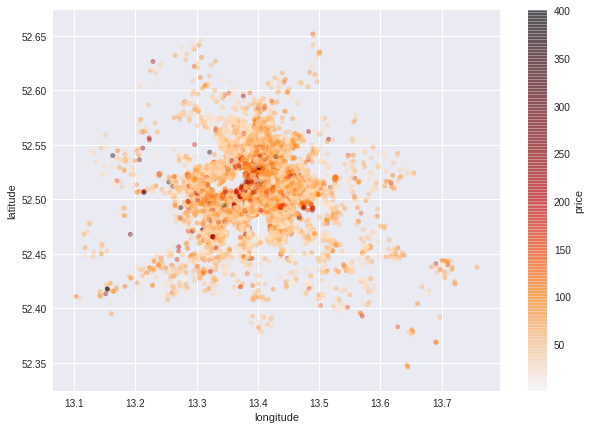

In [72]:
#Price Differences on a Map
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

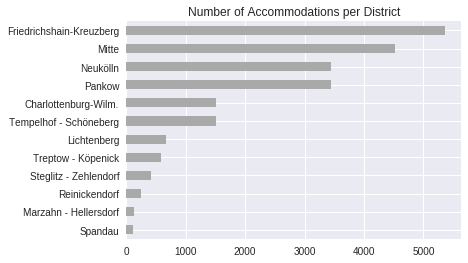

In [73]:
#Price Differences by Neighbourhood
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

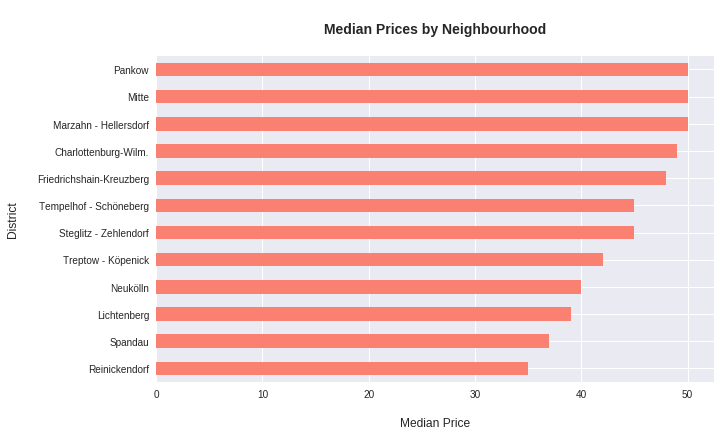

In [74]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

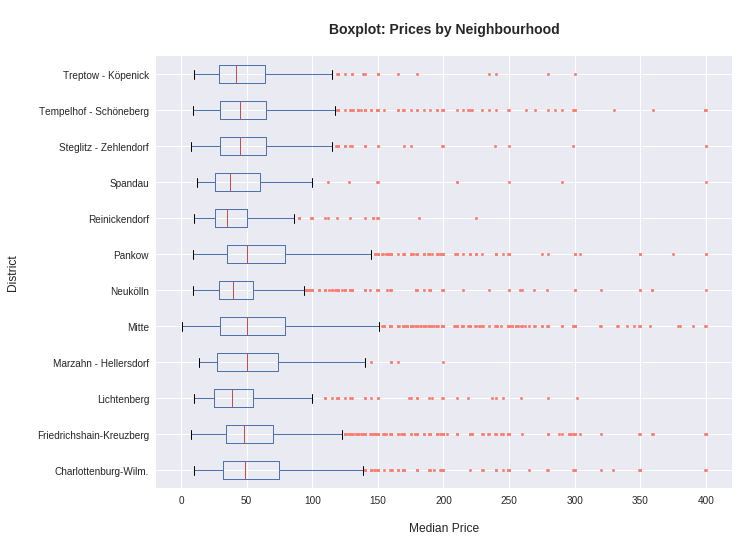

In [75]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

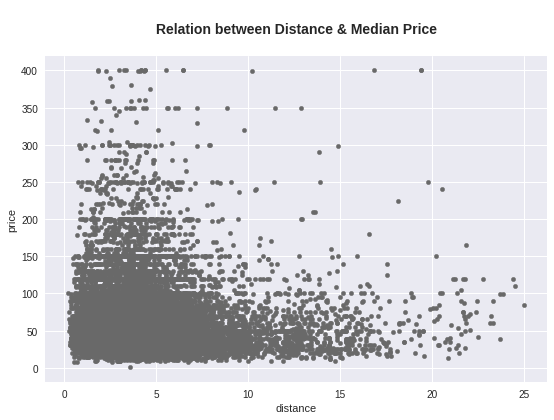

In [76]:
df.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');


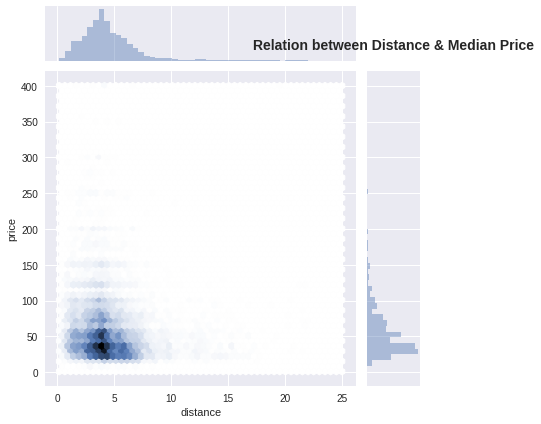

In [77]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

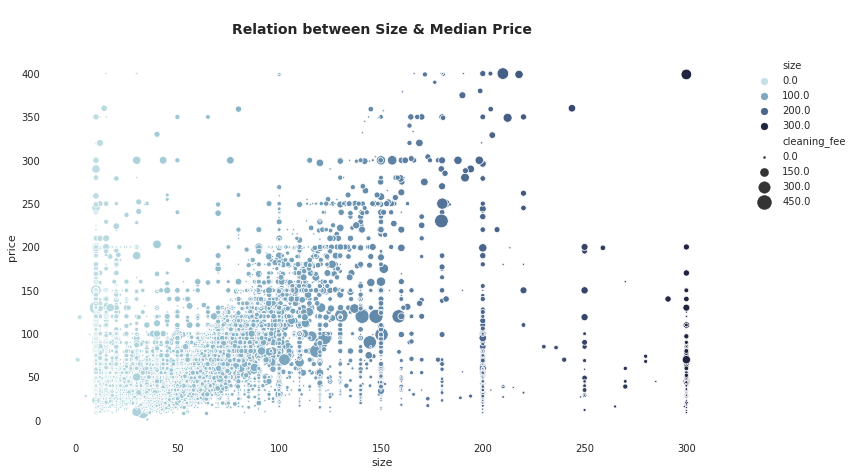

In [78]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);



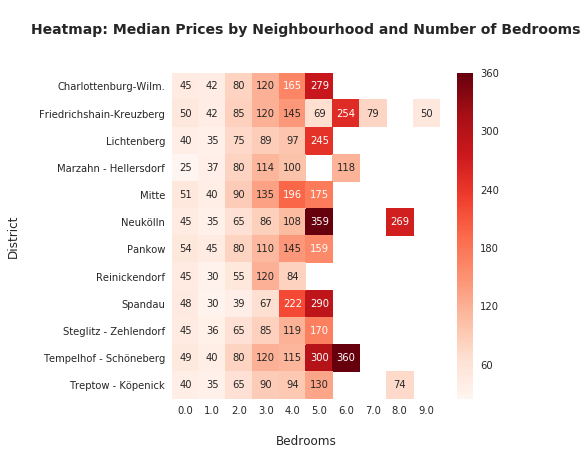

In [79]:
plt.figure(figsize=(6,6))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

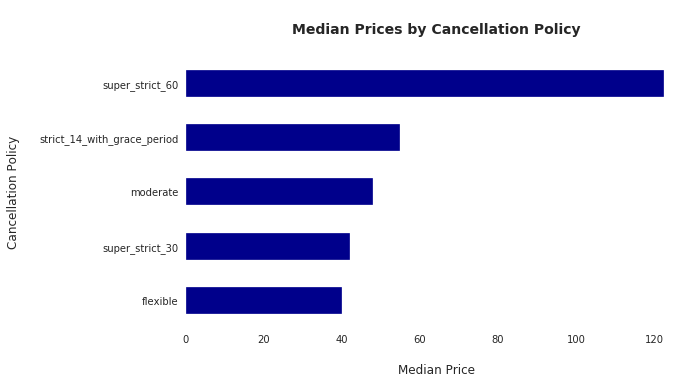

In [80]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

In [81]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance',
       'size', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'Laptop_friendly_workspace', 'TV',
       'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed'],
      dtype='object')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21958 entries, 2015 to 29867352
Data columns (total 26 columns):
accommodates                    21958 non-null int64
bathrooms                       21958 non-null float64
bedrooms                        21958 non-null float64
price                           21958 non-null float64
cleaning_fee                    21958 non-null float64
security_deposit                21958 non-null float64
extra_people                    21958 non-null float64
guests_included                 21958 non-null int64
distance                        21958 non-null float64
size                            21958 non-null float64
host_has_profile_pic            21958 non-null object
neighbourhood_group_cleansed    21958 non-null object
latitude                        21958 non-null float64
longitude                       21958 non-null float64
property_type                   21958 non-null object
room_type                       21958 non-null object
bed_type     

In [83]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

In [84]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [85]:
# define our target
target = df[["price"]]

In [86]:
# define our features 
features = df.drop(["price"], axis=1)

In [87]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [88]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [89]:
print(features_recoded.shape)
features_recoded.head(2)

(21958, 33)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,...,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,...,0,1,1,0,1,1,0,0,0,0


In [90]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

In [91]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [92]:
# create a baseline
booster = xgb.XGBRegressor()

In [93]:
from sklearn.model_selection import GridSearchCV

In [94]:
# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)


[14:23:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [95]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")



[14:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 22.1731


In [96]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.722


In [97]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [98]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [99]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,67.985357,0.713126,68.008407,1.427987
1,65.137787,0.684544,65.202916,1.425047
2,62.508789,0.688720,62.627019,1.394355
3,60.010953,0.626774,60.170582,1.419525
4,57.685021,0.666570,57.918438,1.361274


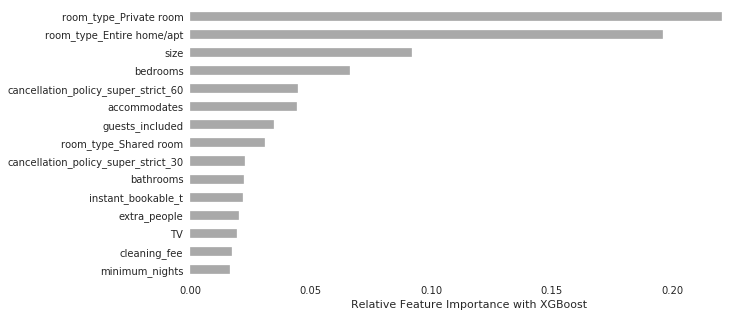

In [100]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');